In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! ln -s /content/drive/MyDrive/src/XAI-CV-CounterfactualSamples .

In [3]:
%cd XAI-CV-CounterfactualSamples

/content/drive/MyDrive/src/XAI-CV-CounterfactualSamples


In [ ]:
! ln -s /content/drive/MyDrive/datasets/HAM10000 datasets

ln: failed to create symbolic link 'datasets/HAM10000': File exists


In [4]:
%cd exp_ham10k

/content/drive/MyDrive/src/XAI-CV-CounterfactualSamples/exp_ham10k


In [5]:
! pip install tensorflow==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

# Initialization

In [6]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.15.1


In [7]:
import importlib
import configs
importlib.reload(configs)

<module 'configs' from '/content/drive/MyDrive/src/XAI-CV-CounterfactualSamples/exp_ham10k/configs.py'>

# Data Loader

In [8]:
class MyDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, subsets_file, subset, batch_size=32, shuffle=False):
        self.data_dir = data_dir
        self.subsets_file = subsets_file
        self.subset = subset
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.filenames = None
        self.classnames = None
        self.dict_class_names = None

        self.load_data()
        self.indices = None
        self.on_epoch_end()

    def load_data(self):
        df_files = pd.read_csv(self.subsets_file)
        self.df_files = df_files[df_files['subset'] == self.subset]
        self.filenames = self.df_files['filename'].tolist()
        self.classnames = self.df_files['classname'].tolist()
        self.dict_class_names = {name:i for i, name in enumerate(configs.CLASS_NAMES)}
        print('*** load_data')
        print(self.subset)
        print(len(self.filenames), 'found')
        print(df_files.head())
        print('***')

    def __len__(self):
        return int(np.ceil(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        filenames = [self.filenames[k] for k in indices]
        classnames = [self.classnames[k] for k in indices]
        X, Y = self.__data_generation(filenames, classnames)
        return X, Y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def toOneHot(self, classname):
        v = np.zeros(configs.NUM_CLASS, dtype=np.float64)
        v[self.dict_class_names[classname]] = 1.0
        return v

    def __data_generation(self, filenames, classnames):
        num = len(filenames)
        X = np.empty([num, *configs.IMAGE_SIZE], dtype=np.float64)
        Y = np.empty([num, configs.NUM_CLASS])
        HH, WW, _ = configs.IMAGE_SIZE
        for i, fn in enumerate(filenames):
            img = plt.imread(configs.DATA_DIR+'/'+fn)
            delta = (WW - HH) // 2
            img = img[:, delta:WW-delta-1]
            img = cv2.resize(img, configs.IMAGE_SIZE[:2])
            X[i] = np.array(img, dtype=np.float64) / 255.
            Y[i] = self.toOneHot(classnames[i])

        return X, Y

In [9]:
train_datagen = MyDataGenerator(configs.DATA_DIR, configs.SUBSETS_FILE, 'train', shuffle=True)
val_datagen = MyDataGenerator(configs.DATA_DIR, configs.SUBSETS_FILE, 'val', shuffle=True)
test_datagen = MyDataGenerator(configs.DATA_DIR, configs.SUBSETS_FILE, 'test', shuffle=True)

*** load_data
train
5005 found
                      filename subset classname
0  test/akiec/ISIC_0028232.jpg   test     akiec
1  test/akiec/ISIC_0033000.jpg   test     akiec
2  test/akiec/ISIC_0029059.jpg   test     akiec
3  test/akiec/ISIC_0033413.jpg   test     akiec
4  test/akiec/ISIC_0031198.jpg   test     akiec
***
*** load_data
val
2000 found
                      filename subset classname
0  test/akiec/ISIC_0028232.jpg   test     akiec
1  test/akiec/ISIC_0033000.jpg   test     akiec
2  test/akiec/ISIC_0029059.jpg   test     akiec
3  test/akiec/ISIC_0033413.jpg   test     akiec
4  test/akiec/ISIC_0031198.jpg   test     akiec
***
*** load_data
test
3010 found
                      filename subset classname
0  test/akiec/ISIC_0028232.jpg   test     akiec
1  test/akiec/ISIC_0033000.jpg   test     akiec
2  test/akiec/ISIC_0029059.jpg   test     akiec
3  test/akiec/ISIC_0033413.jpg   test     akiec
4  test/akiec/ISIC_0031198.jpg   test     akiec
***


(32, 256, 256, 3) (32, 7)


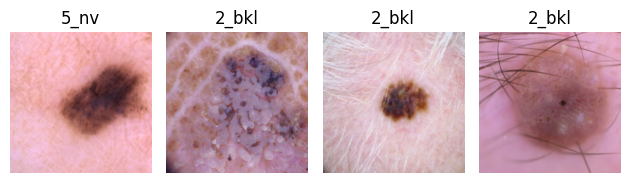

In [ ]:
X, Y = train_datagen[0]
print(X.shape, Y.shape)

for i in range(4):
  plt.subplot(1, 4, i+1)
  plt.imshow((X[i]*255).astype(np.uint8))
  plt.axis('off')
  class_id = Y[i].argmax()
  plt.title(str(class_id)+'_'+configs.CLASS_NAMES[class_id])
plt.tight_layout()
plt.show()

# Classifer 256 x 256

In [ ]:
model = tf.keras.models.Sequential(name='classifier256')
model.add(tf.keras.applications.resnet50.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=configs.IMAGE_SIZE)
)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(configs.NUM_CLASS, activation='sigmoid'))
model.add(tf.keras.layers.Softmax())
model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "classifier256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
 softmax (Softmax)           (None, 7)                 0         
                                                                 
Total params: 23602055 (90.03 MB)
Trainable params: 23548935 (89.83 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Training

In [ ]:
cb_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=5,
    verbose=1,
    mode='auto'
)
cb_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    configs.CHECKPOINTS_DIR + '/' + model.name,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto'
)
cb_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=1e-4,
    min_lr=0
)

callbacks = [cb_model_checkpoint,
             cb_reduce_lr,
             cb_early_stop]

In [ ]:
history = model.fit_generator(train_datagen,
                    epochs=2024,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=val_datagen)

pd.DataFrame.from_dict(history.history) \
            .to_csv(configs.CHECKPOINTS_DIR+'/'+
                    model.name+'/history_classifer.csv',
                    index=False)

<ipython-input-20-131ce7972937>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen,


Epoch 1/2024
157/157 [==============================] - ETA: 0s - loss: 1.3942 - accuracy: 0.7447 
Epoch 1: val_loss improved from inf to 1.52650, saving model to checkpoints/classifier256
157/157 [==============================] - 5623s 36s/step - loss: 1.3942 - accuracy: 0.7447 - val_loss: 1.5265 - val_accuracy: 0.6705 - lr: 1.0000e-04
Epoch 2/2024
157/157 [==============================] - ETA: 0s - loss: 1.3127 - accuracy: 0.8212
Epoch 2: val_loss did not improve from 1.52650
157/157 [==============================] - 80s 507ms/step - loss: 1.3127 - accuracy: 0.8212 - val_loss: 1.5976 - val_accuracy: 0.6705 - lr: 1.0000e-04
Epoch 3/2024
157/157 [==============================] - ETA: 0s - loss: 1.2791 - accuracy: 0.8629
Epoch 3: val_loss improved from 1.52650 to 1.49495, saving model to checkpoints/classifier256
157/157 [==============================] - 105s 670ms/step - loss: 1.2791 - accuracy: 0.8629 - val_loss: 1.4949 - val_accuracy: 0.6705 - lr: 1.0000e-04
Epoch 4/2024
157/157

AttributeError: module 'configs' has no attribute 'CHECKPOINT_DIRS'

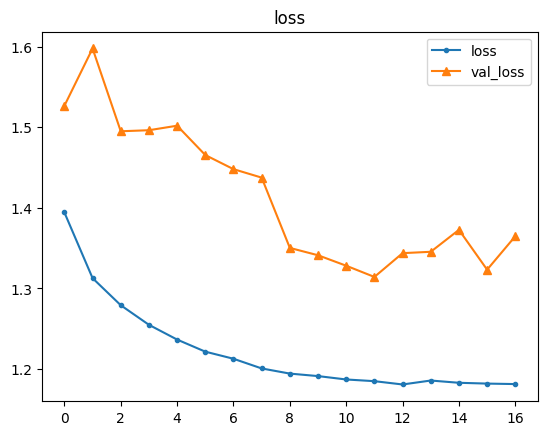

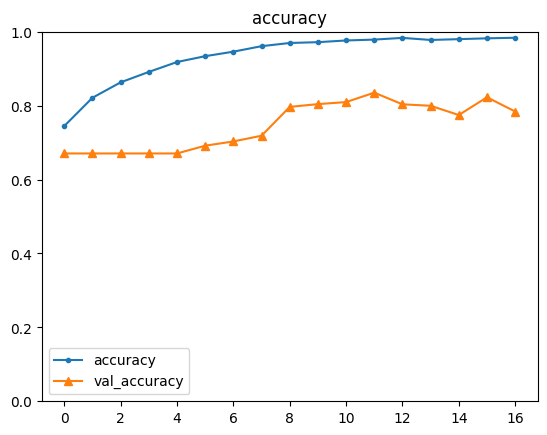

In [ ]:
df = pd.read_csv(configs.CLASSIFIER256_CHECKPOINT+'/history_classifier.csv')

plt.plot(df['loss'], label='loss', marker='.')
plt.plot(df['val_loss'], label='val_loss', marker='^')
plt.legend()
plt.title('loss')
plt.show()

plt.plot(df['accuracy'], label='accuracy', marker='.')
plt.plot(df['val_accuracy'], label='val_accuracy', marker='^')
plt.legend()
plt.title('accuracy')
plt.ylim(0, 1)
plt.show()

# Evaluation

In [11]:
model = tf.keras.models.load_model(configs.CLASSIFIER256_CHECKPOINT)
train_loss, train_acc = model.evaluate_generator(train_datagen, verbose=1)
val_loss, val_acc = model.evaluate_generator(val_datagen, verbose=1)
test_loss, test_acc = model.evaluate_generator(test_datagen, verbose=1)
print(train_loss, val_loss, test_loss)
print(train_acc, val_acc, test_acc)

<ipython-input-11-7378ade8b9f9>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_acc = model.evaluate_generator(train_datagen, verbose=1)


157/157 [==============================] - 1987s 13s/step - loss: 1.1855 - accuracy: 0.9798


<ipython-input-11-7378ade8b9f9>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_acc = model.evaluate_generator(val_datagen, verbose=1)


63/63 [==============================] - 773s 12s/step - loss: 1.3142 - accuracy: 0.8350


<ipython-input-11-7378ade8b9f9>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_datagen, verbose=1)


95/95 [==============================] - 1217s 13s/step - loss: 1.3248 - accuracy: 0.8229
1.1854877471923828 1.3142328262329102 1.3248164653778076
0.979820191860199 0.8349999785423279 0.8229236006736755


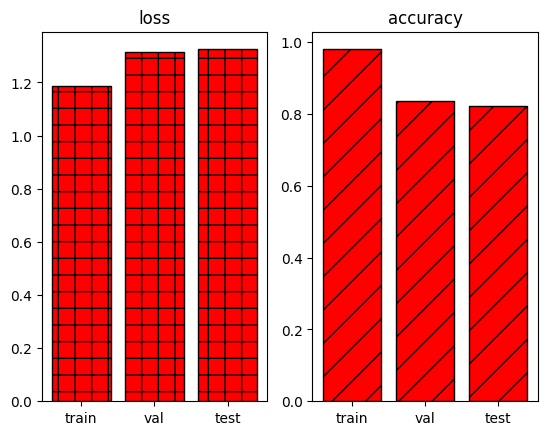

In [14]:
plt.subplot(1, 2, 1)
plt.bar(['train', 'val', 'test'], [1.1855, 1.3142, 1.3248], color='red',
                                edgecolor='black', hatch='+')
plt.title('loss')
plt.subplot(1, 2, 2)
plt.bar(['train', 'val', 'test'], [0.9798, 0.8350, 0.8229], color='red',
                                edgecolor='black', hatch='/')
plt.title('accuracy')
plt.show()